In [1]:
# imports
%cd ..
import os
from tqdm.notebook import tqdm
from mango.environments import frozen_lake
from mango import Agent, Mango
from frozen_lake_tests import utils_plot, utils_save

/home/davide_sartor/MANGO-lite


Experiment Parameters

In [2]:
# parameters for the environment
map_base = 3
map_scale = 3
p_frozen = None
one_shot = True

plot_confront = True
plot_training_evolution = False
plot_qvalues = True
ignore_agent = True

0it [00:00, ?it/s]

mango_agent_run_00.pickle
mango_agent_run_00.pickle


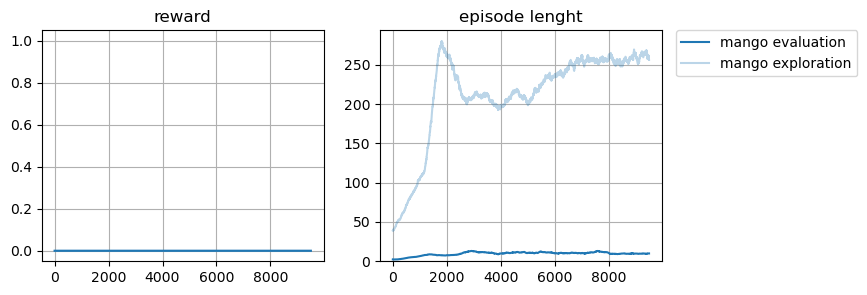

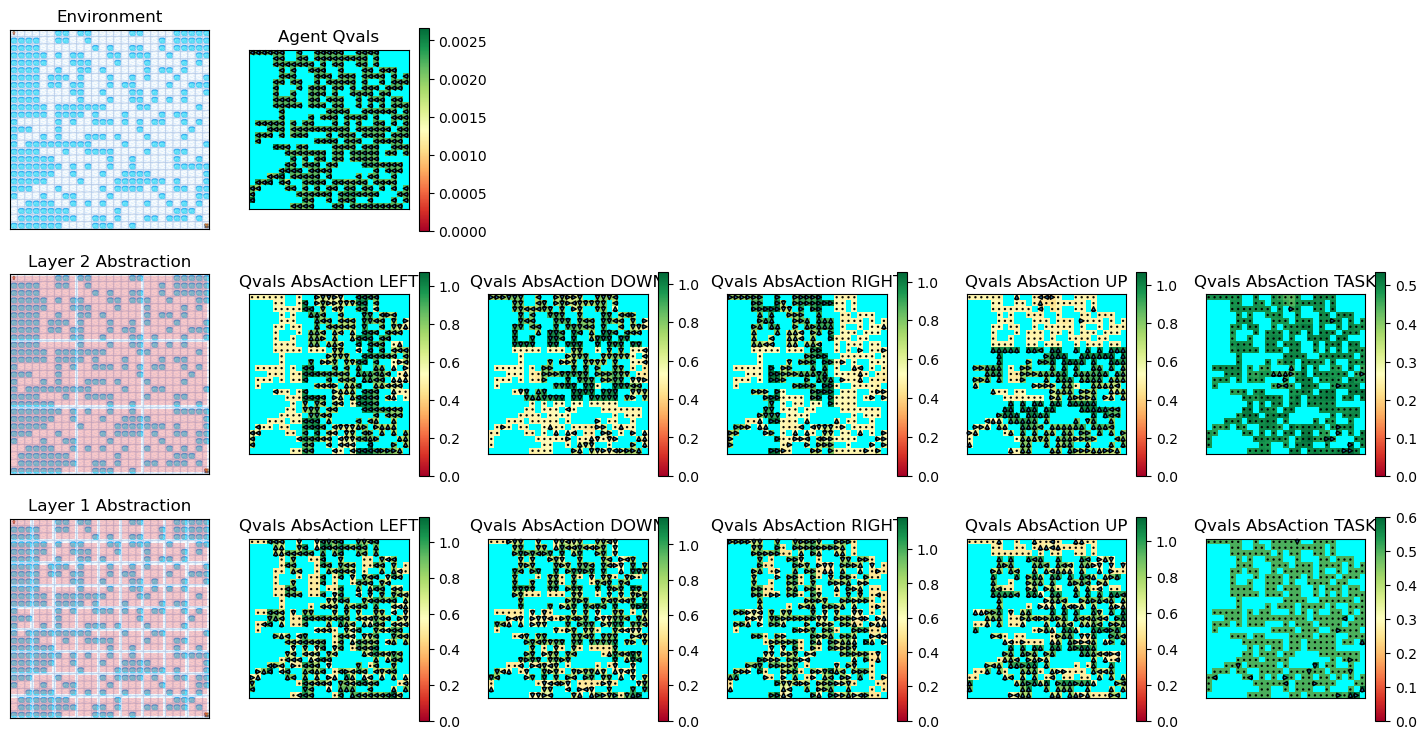

mango_agent_run_01.pickle
mango_agent_run_01.pickle


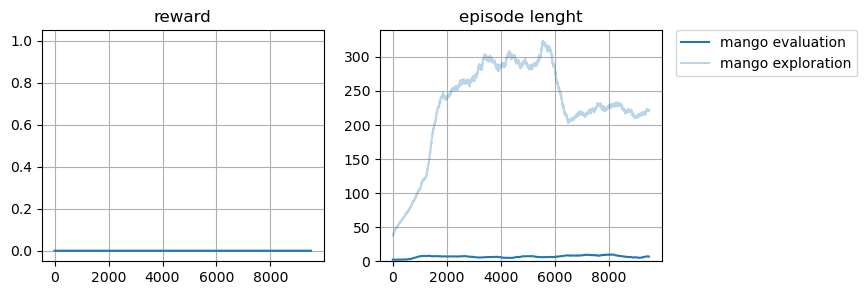

In [3]:
# load agent models one by one
dir_path = utils_save.path_to_save_dir(map_base, map_scale, p_frozen, one_shot)
files = sorted(os.listdir(dir_path + "models/"))
mango_agent_files = [name for name in files if name.startswith("mango_agent")]
if ignore_agent:
    normal_agent_files = mango_agent_files
else:
    normal_agent_files = [name for name in files if name.startswith("normal_agent")]

for mango_agent_file, normal_agent_file in tqdm(zip(mango_agent_files, normal_agent_files)):
    print(normal_agent_file)
    print(mango_agent_file)
    run_id_str = f"run_{normal_agent_file[-9:-7]}"
    normal_agent: Agent = utils_save.load_from_file(dir_path + "models/" + normal_agent_file)
    mango_agent: Mango = utils_save.load_from_file(dir_path + "models/" + mango_agent_file)

    if plot_confront:
        os.makedirs(dir_path + "comparisons/", exist_ok=True)
        utils_plot.plot_confront_loss_reward(
            agents=[normal_agent, mango_agent] if not ignore_agent else [mango_agent],
            labels=["vanilla", "mango"] if not ignore_agent else ["mango"],
            save_path=f"{dir_path}comparisons/compare_reward_{run_id_str}.pdf",
        )

    if plot_training_evolution:
        os.makedirs(dir_path + "training/", exist_ok=True)
        if not ignore_agent:
            utils_plot.plot_normal_agent_loss_reward(
                normal_agent,
                save_path=f"{dir_path}training/train_results_{run_id_str}_normal_agent.pdf",
            )
        utils_plot.plot_mango_agent_loss_reward(
            mango_agent,
            save_path=f"{dir_path}training/train_results_{run_id_str}_mango_agent.pdf",
        )

    if plot_qvalues:
        os.makedirs(dir_path + "qvalues/", exist_ok=True)
        if not ignore_agent:
            normal_agent.reset()
            trajectory, rewards = normal_agent.run_episode(
                randomness=0.0, episode_length=4**map_scale
            )
            frozen_lake.plot_utils.plot_all_qvals_normal_agent(
                normal_agent,
                trajectory,
                save_path=f"{dir_path}qvalues/qvalues_{run_id_str}_normal_agent.pdf",
            )
        mango_agent.reset()
        trajectory, rewards = mango_agent.run_episode(randomness=0.0, episode_length=4**map_scale)
        frozen_lake.plot_utils.plot_all_qvals_mango_agent(
            mango_agent,
            trajectory,
            save_path=f"{dir_path}qvalues/qvalues_{run_id_str}_mango_agent.pdf",
        )